In [1]:
%load_ext snakeviz

In [2]:
import itertools
import os

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import HTML, Markdown, display
from functools import reduce

MEASUREMENTS_FOLDER = "Variance logs"

setting_names = set(
    [
        "texture size",
        "downscale",
        "number of clusters",
        "number of iterations",
        "random swap",
        "randomize empty clusters",
        "KHM",
        "staggered jitter",
        "jitter size",
        "video file",
    ]
)

def load_measurements(measurement_name: str):
    log_file_names = os.listdir(f"{MEASUREMENTS_FOLDER}/{measurement_name}")
    
    def setting_transform(value):
        match value:
            case "True":
                return "Yes"
            case "False":
                return "No"
        return value

    def test(x):
        print(x)
        return x
    
    measurements = [
        {
            "settings" : {
                setting_name : setting_transform(setting_value)
                    for setting_name, setting_value in [
                            setting_text.split(':')
                                for setting_text in file_name.split('.')[0].split("|")
                        ]
            },
            "variance" : pd.read_csv(
                f"{MEASUREMENTS_FOLDER}/{measurement_name}/{file_name}"
            )["Variance"].tolist()[10:-10], # first and lust 10 frames removed
            "file name" : file_name
        }
        for file_name in log_file_names
    ]
    
    for measurement in measurements:
        assert (
            set(
                measurement["settings"].keys()
            ) == set(
                setting_names
            )
        )
    
    for measurement in measurements:
        measurement["total variance"] = sum(measurement["variance"]) / len(measurement["variance"])
    
    for measurement in measurements:
        measurement["peak variance"] = max(measurement["variance"])
    
    return measurements

def show_measurements_table(measurements):    
    def get_setting_value_lengths(measurements):
        return {
            setting_name : max(
                max(
                    [
                        len(measurement['settings'][setting_name])
                            for measurement in measurements
                    ]
                ),
                len(setting_name)
            )
            for setting_name in setting_names
        }
    
    def get_settings_same_everywhere(measurements):
        def is_setting_same_everywhere(setting_name):
            for measurement in measurements:
                if measurement["settings"][setting_name] != measurements[0]["settings"][setting_name]:
                    return False
            return True
        return [setting_name for setting_name in setting_names if is_setting_same_everywhere(setting_name)]
    
    setting_value_lengths = get_setting_value_lengths(measurements)
    settings_same_everywhere = get_settings_same_everywhere(measurements)
    
    def print_setting(name, value):
        print(value, end="")
        print(
            " " * (
                setting_value_lengths[name] - len(value)
            ),
            end=""
        )


    for setting_name in setting_names:
        if setting_name in settings_same_everywhere:
            continue
        print(setting_name, end="")
        print("  |  ", end="")
    print("variance")
    print("-" *
        (
            sum(
                [
                    setting_value_lengths[name] + 5
                    for name in setting_names
                    if not name in settings_same_everywhere
                ]
            ) + 8
        )
    )

    for measurement in measurements:
        for setting_name in setting_names:
            if setting_name in settings_same_everywhere:
                continue
            print_setting(setting_name, measurement['settings'][setting_name])
            print("  |  ", end="")
        total_variance_string = f"{measurement['total variance']:0.5f}"
        print(f'{total_variance_string:10}', end="")
        print()

In [3]:
def plot_diff(index1, index2):    
    diff = [
        a - b for a,b in zip(
            logs[index1]["variance"],
            logs[index2]["variance"]
        )
    ]
    
    _, ax = plt.subplots()
    
    sb.lineplot(
        x=logs[index1]["Frame"],
        y=diff,
        ax=ax,
        label=f"{names[index1]} -\n{names[index2]}"
    )    
    plt.ylabel("ΔVariance")
    
    plt.show() # display plots RIGHT NOW
    
def plot_log(indices, do_plot_diff = False):    
    _, ax = plt.subplots()
    
    for logIndex in indices:
        sb.lineplot(
            x=logs[logIndex]["Frame"],
            y=logs[logIndex]["variance"],
            ax=ax,
            label=names[logIndex]
        )
    
    if do_plot_diff:
        assert(len(indices) == 2)
        plot_diff(indices[0], indices[1])
    
    plt.show() # display plots RIGHT NOW

In [4]:
def init_seaborn():
    sb.set(
        font_scale=1.2,
        rc={
            "figure.figsize":(14, 6)
        },
        palette="deep"
    )

init_seaborn()

In [5]:
display(Markdown("# ToDo measurements"))

display(
    Markdown(
"""
|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.
"""
    )
)

# ToDo measurements


|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.


In [6]:
display(Markdown('# Dataset 1: subsampling'))

M1 = load_measurements("1. subsampling")

M1 = sorted(
    M1,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
    )
)


show_measurements_table(M1)

# Dataset 1: subsampling

number of clusters  |  video file  |  texture size  |  variance
---------------------------------------------------------------
4                   |  1           |  512           |  0.01443   
6                   |  1           |  512           |  0.00765   
8                   |  1           |  512           |  0.00496   
12                  |  1           |  512           |  0.00243   
16                  |  1           |  512           |  0.00151   
4                   |  1           |  256           |  0.01443   
6                   |  1           |  256           |  0.00766   
8                   |  1           |  256           |  0.00496   
12                  |  1           |  256           |  0.00244   
16                  |  1           |  256           |  0.00152   
4                   |  1           |  128           |  0.01443   
6                   |  1           |  128           |  0.00765   
8                   |  1           |  128           |  0.00497   
12            

## Plots

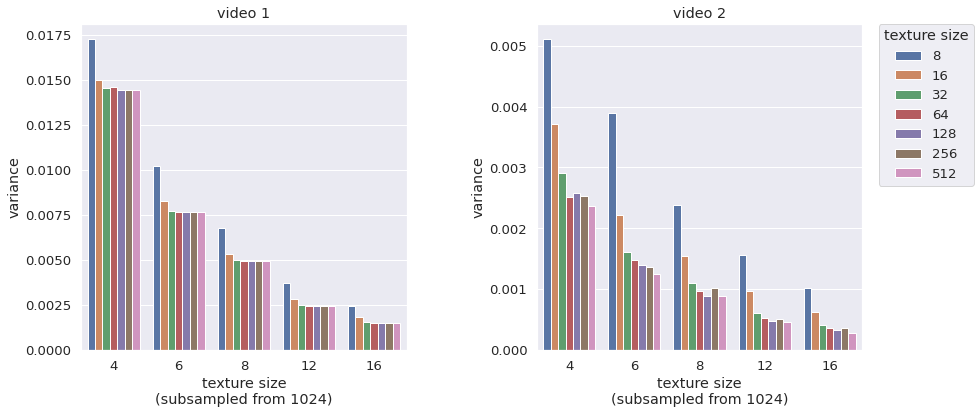

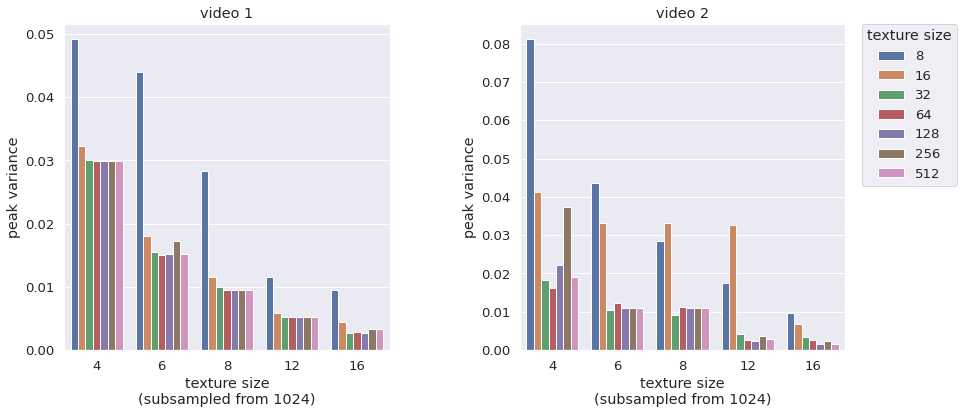

In [7]:
display(Markdown("## Plots"))

def subsample_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "number of clusters"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=total_variance_by_texture_size["video 1"]["number of clusters"],
        y=total_variance_by_texture_size["video 1"]["total variance"],
        ax=axes[0],
        hue=total_variance_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_variance_by_texture_size["video 2"]["number of clusters"],
        y=total_variance_by_texture_size["video 2"]["total variance"],
        ax=axes[1],
        hue=total_variance_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
def subsample_peak_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "number of clusters"]
        )



    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=data["video 1"]["number of clusters"],
        y=data["video 1"]["peak variance"],
        ax=axes[0],
        hue=data["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("peak variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=data["video 2"]["number of clusters"],
        y=data["video 2"]["peak variance"],
        ax=axes[1],
        hue=data["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("peak variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
subsample_variance_plots()
subsample_peak_variance_plots()

In [8]:
display(Markdown('# Dataset 2: scaling vs subsampling'))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

# Dataset 2: scaling vs subsampling

video file  |  texture size  |  downscale  |  variance
------------------------------------------------------
1           |  512           |  No         |  0.00765   
1           |  512           |  Yes        |  0.00765   
1           |  256           |  No         |  0.00766   
1           |  256           |  Yes        |  0.00773   
1           |  128           |  No         |  0.00765   
1           |  128           |  Yes        |  0.00765   
1           |  64            |  No         |  0.00764   
1           |  64            |  Yes        |  0.00766   
1           |  32            |  No         |  0.00772   
1           |  32            |  Yes        |  0.00783   
1           |  16            |  No         |  0.00827   
1           |  16            |  Yes        |  0.00809   
1           |  8             |  No         |  0.01019   
1           |  8             |  Yes        |  0.00966   
2           |  512           |  No         |  0.00125   
2           |  512           |  Yes

## Plots

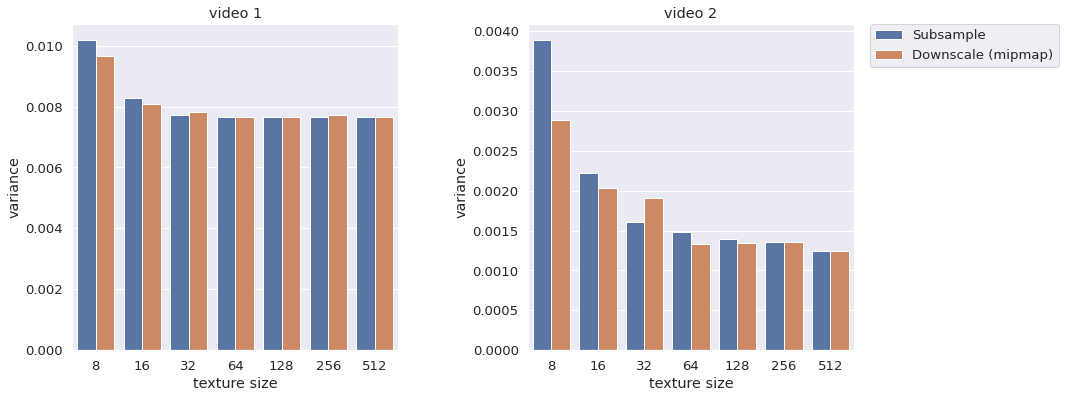

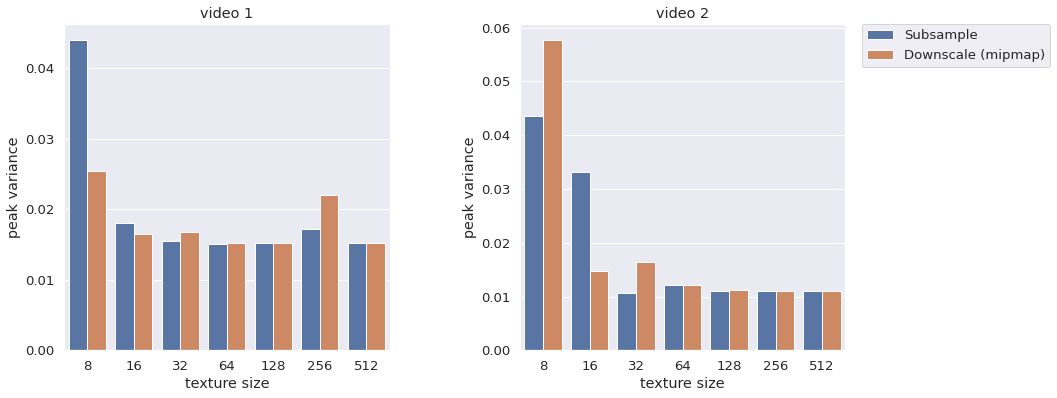

In [9]:
display(Markdown("## Plots"))

def subsample_vs_downscale_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['texture size']),
                    
                    "Downscale (mipmap)"
                            if measurement['settings']['downscale'] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["total variance", "peak variance", "texture size", "downscale"]
        )

    data_frames = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
        )
        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
        )
        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    plot_variance()
    plot_peak_variance()

subsample_vs_downscale_plots()

In [10]:
display(Markdown('## Jitter'))

## Jitter

In [11]:
display(Markdown('## Dataset 3: staggered jitter'))

M3 = load_measurements("3. staggered jitter")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)


show_measurements_table(M3)

## Dataset 3: staggered jitter

video file  |  texture size  |  jitter size  |  variance
--------------------------------------------------------
1           |  64            |  1            |  0.00764   
1           |  32            |  1            |  0.00772   
1           |  32            |  2            |  0.00774   
1           |  16            |  1            |  0.00827   
1           |  16            |  2            |  0.00832   
1           |  16            |  4            |  0.00812   
1           |  8             |  1            |  0.01019   
1           |  8             |  2            |  0.01012   
1           |  8             |  4            |  0.00982   
1           |  8             |  8            |  0.00970   
1           |  4             |  1            |  0.01538   
1           |  4             |  16           |  0.01450   
1           |  4             |  2            |  0.01513   
1           |  4             |  4            |  0.01496   
1           |  4             |  8            |  0.01500   
2

In [12]:
display(Markdown('## Dataset 4: scanline jitter'))

M4 = load_measurements("4. scanline jitter")

M4 = sorted(
    M4,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)

show_measurements_table(M4)

## Dataset 4: scanline jitter

video file  |  texture size  |  jitter size  |  variance
--------------------------------------------------------
1           |  64            |  1            |  0.00764   
1           |  32            |  1            |  0.00772   
1           |  32            |  2            |  0.00772   
1           |  16            |  1            |  0.00827   
1           |  16            |  2            |  0.00814   
1           |  16            |  4            |  0.00815   
1           |  8             |  1            |  0.01019   
1           |  8             |  2            |  0.01004   
1           |  8             |  4            |  0.00994   
1           |  8             |  8            |  0.01005   
1           |  4             |  1            |  0.01538   
1           |  4             |  16           |  0.01518   
1           |  4             |  2            |  0.01507   
1           |  4             |  4            |  0.01554   
1           |  4             |  8            |  0.01532   
2

### Plots

#### Staggered jitter

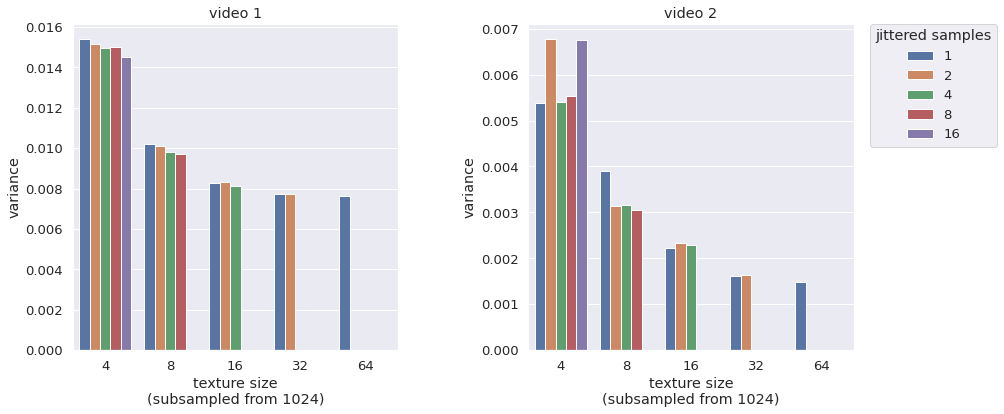

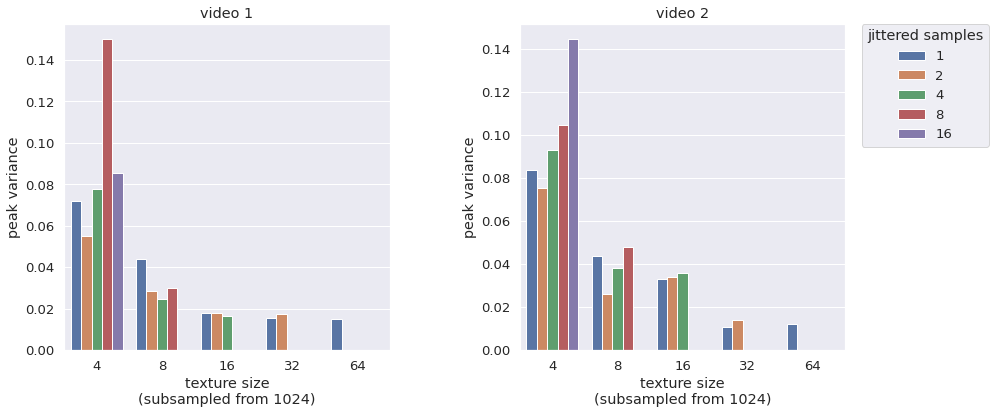

#### Scanline jitter

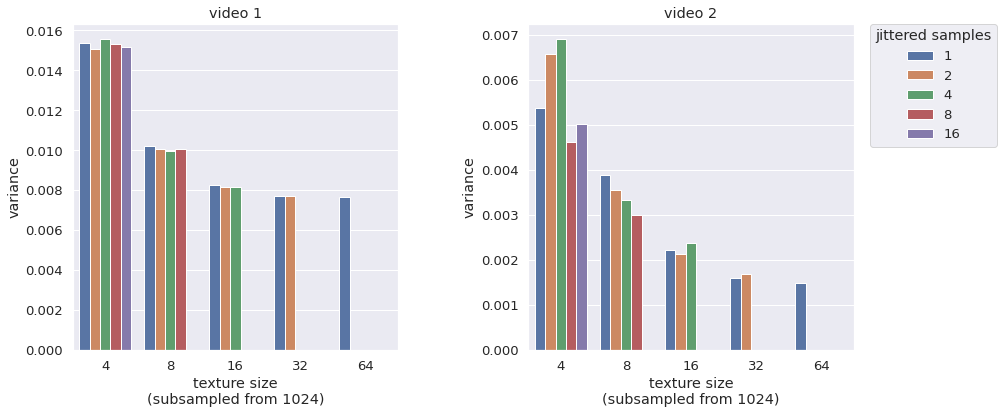

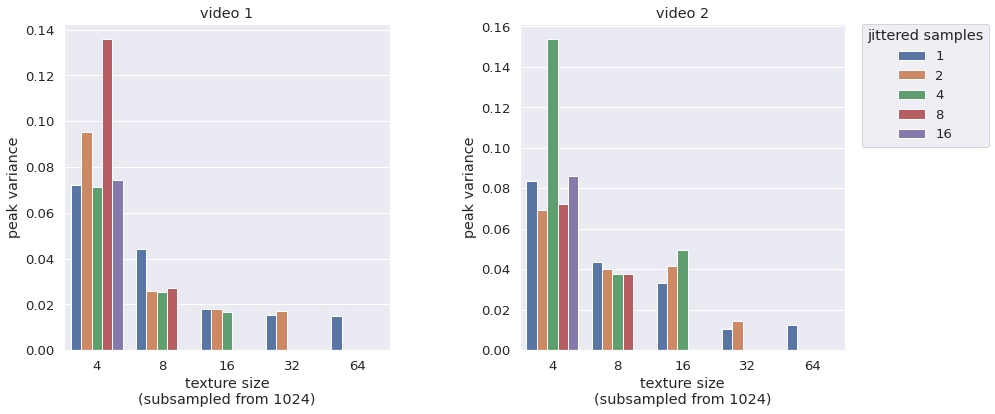

#### Difference

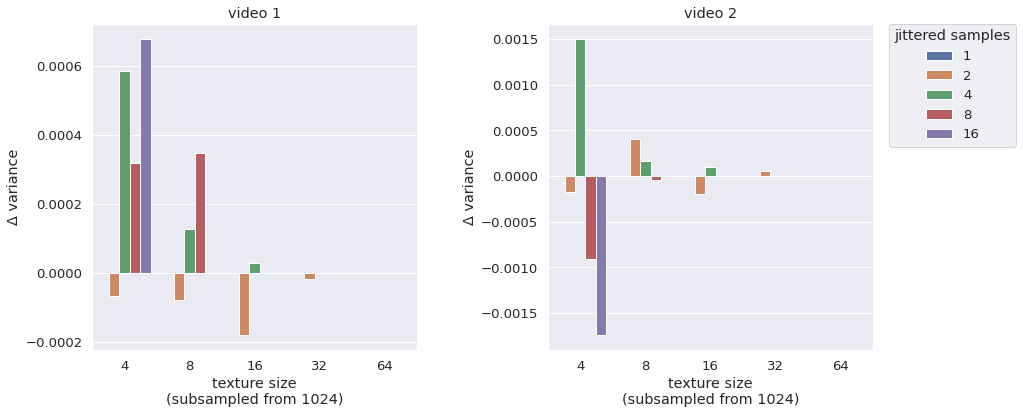

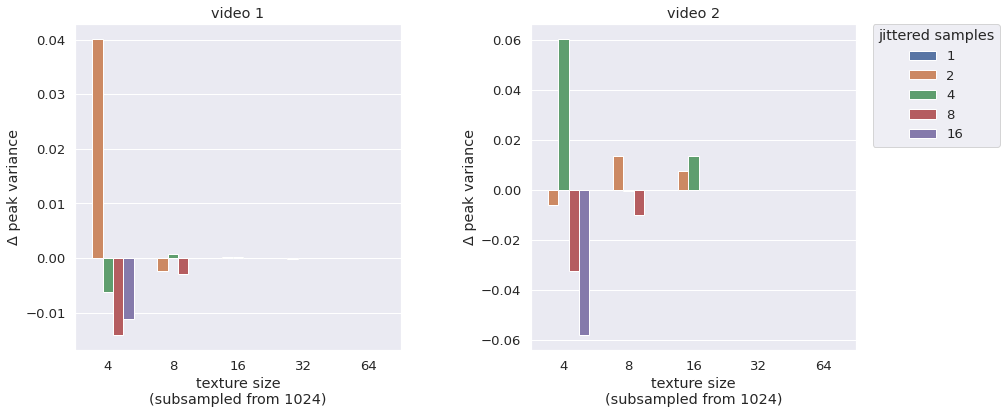


Positive numbers mean variance is greater with scanline jitter.
            

In [13]:
display(Markdown("### Plots"))

def jitter_plots():
    
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['jitter size'])
                )
                    for measurement in measurements
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "jitter size"]
        )
    
    def load_video_delta(video_name):
        return pd.DataFrame(
            [
                (
                    int(M4[i]['settings']['texture size']),
                    M4[i]['total variance'] - M3[i]['total variance'],
                    M4[i]['peak variance'] - M3[i]['peak variance'],
                    int(M4[i]['settings']['jitter size'])
                )
                    for i in range(len(M4))
                        if M4[i]['settings']["video file"] == video_name
            ],
            columns=["texture size", "delta variance", "delta peak variance", "jitter size"]
        )


    data_frames_staggered_jitter = {
        f"video {video}" : load_video(video, M3)
            for video in ["1", "2"]
    }
    
    data_frames_scanline_jitter = {
        f"video {video}" : load_video(video, M4)
            for video in ["1", "2"]
    }
    
    data_frames_delta = {
        f"video {video}" : load_video_delta(video)
            for video in ["1", "2"]
    }

    display(Markdown("#### Staggered jitter"))
    
    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()    
    
    display(Markdown("#### Scanline jitter"))

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()
    
    display(Markdown("#### Difference"))
    
    def plot_delta_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_delta_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_delta_variance()
    plot_delta_peak_variance()
    
    display(
        Markdown(
            """
Positive numbers mean variance is greater with scanline jitter.
            """
        )
    )

jitter_plots()

display(
    Markdown(
        """

        """
    )
)

In [14]:
display(Markdown('# Dataset 5: empty cluster randomization'))

M5 = load_measurements("5. empty cluster randomization")

M5 = sorted(
    M5,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["randomize empty clusters"],
    )
)

show_measurements_table(M5)

# Dataset 5: empty cluster randomization

video file  |  texture size  |  randomize empty clusters  |  variance
---------------------------------------------------------------------
1           |  512           |  No                        |  0.00765   
1           |  512           |  Yes                       |  0.00765   
1           |  256           |  No                        |  0.00766   
1           |  256           |  Yes                       |  0.00766   
1           |  128           |  No                        |  0.00765   
1           |  128           |  Yes                       |  0.00765   
1           |  64            |  No                        |  0.00764   
1           |  64            |  Yes                       |  0.00767   
1           |  32            |  No                        |  0.00772   
1           |  32            |  Yes                       |  0.00773   
1           |  16            |  No                        |  0.00827   
1           |  16            |  Yes                       |  0.00824

## Plots

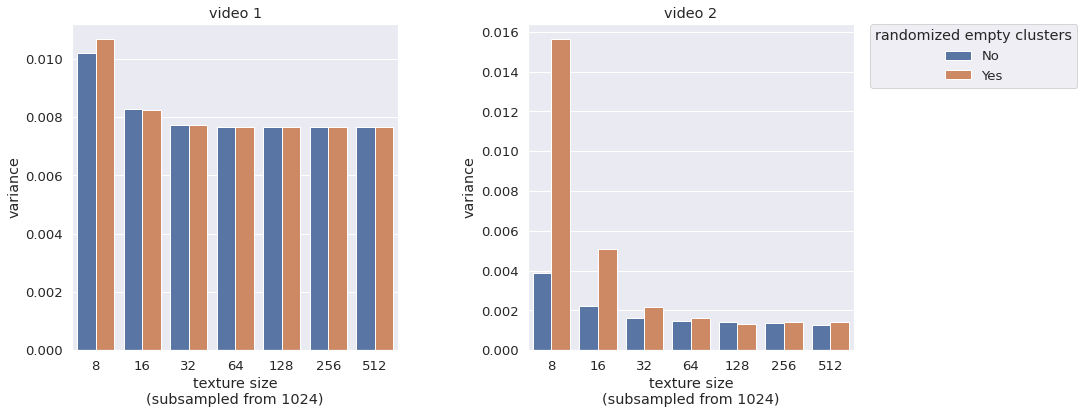

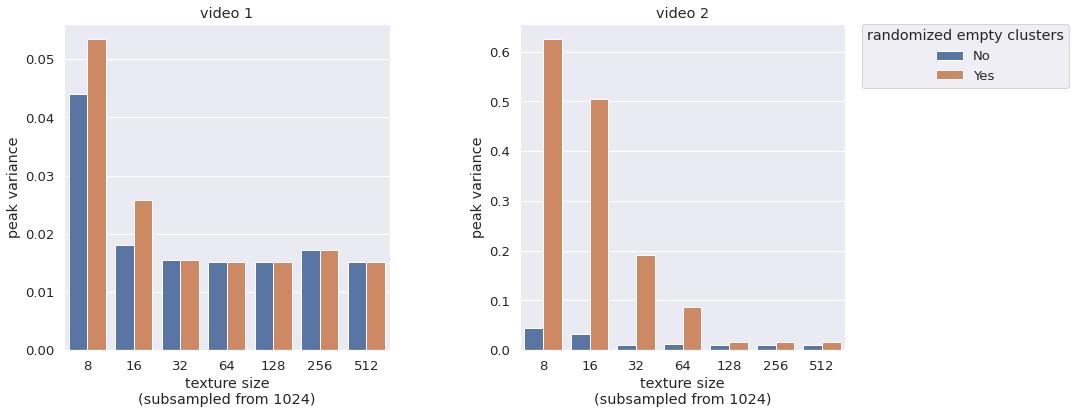

In [15]:
display(Markdown("## Plots"))

def randomized_empty_clusters_plots():

    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    measurement['settings']['randomize empty clusters'],
                )
                    for measurement in M5
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "randomized empty clusters"]
        )
    
    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    def randomized_empty_clusters_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["total variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["total variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    def randomized_empty_clusters_peak_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    randomized_empty_clusters_variance_plots()
    randomized_empty_clusters_peak_variance_plots()

randomized_empty_clusters_plots()

In [16]:
display(Markdown('# Dataset 6: KHM and random swap'))

M6 = load_measurements("6. KHM and random swap")

M6 = sorted(
    M6,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        int(measurement["settings"]["number of iterations"]),
        measurement["settings"]["random swap"],
        measurement["settings"]["KHM"],
    )
)

show_measurements_table(M6)

# Dataset 6: KHM and random swap

KHM  |  number of iterations  |  video file  |  random swap  |  variance
------------------------------------------------------------------------
No   |  3                     |  1           |  No           |  0.00764   
Yes  |  3                     |  1           |  No           |  0.00767   
No   |  3                     |  1           |  Yes          |  0.00764   
No   |  5                     |  1           |  No           |  0.00761   
Yes  |  5                     |  1           |  No           |  0.00765   
No   |  5                     |  1           |  Yes          |  0.00761   
No   |  7                     |  1           |  No           |  0.00760   
Yes  |  7                     |  1           |  No           |  0.00764   
No   |  7                     |  1           |  Yes          |  0.00760   
No   |  9                     |  1           |  No           |  0.00759   
Yes  |  9                     |  1           |  No           |  0.00766   
No   |  9                    

## Plots

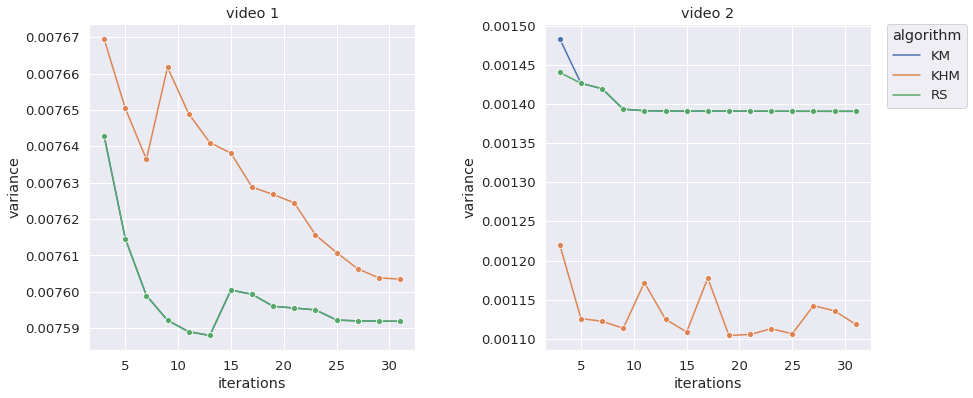

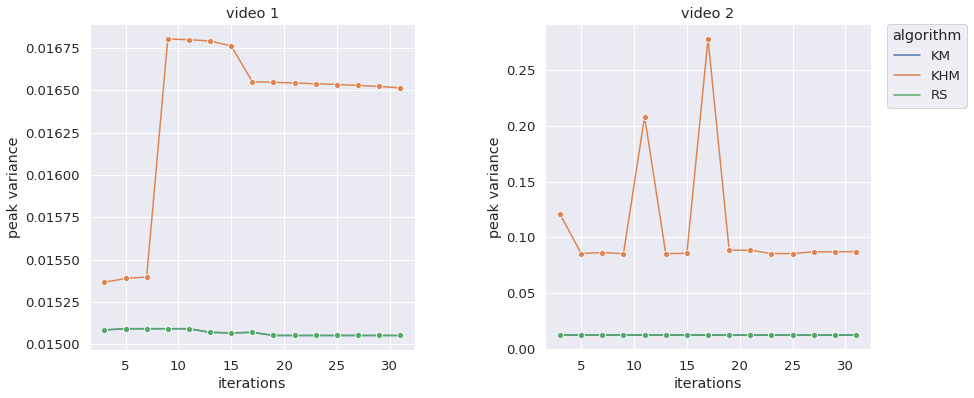


KM overlaps with RS<br>
=> this tells us, that KM never got stuck in a local minimum

## Explanation

KHM converges slower than KM on good initializations.
In this case initialization is good, as demonstrated by RS aligning with KM.

If the initialization was bad, RS would eventually find a better solution than KM.

Slower convergence of KHM causes higher peaks (maybe?).

## Trade-off
* RS and KM have reliably lower peaks than KHM
* KHM is resistant against local minimum with a single iteration
* KM did not get stuck in a local minimum a single time

KHM was implemented with $p=3$ because integer exponent can be optimized by replacing exponentiation with multiplication.
        

In [17]:
display(Markdown("## Plots"))

def modes_plot():
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    "KHM" if  measurement['settings']['KHM'] == "Yes"
                        else
                            "RS" if measurement['settings']['random swap'] == "Yes"
                        else
                            "KM",
                    measurement['total variance'], # + (0.00001 if measurement['settings']['random swap'] == "Yes" else 0),
                    measurement['peak variance'],
                    int(measurement['settings']['number of iterations']),
                )
                    for measurement in measurements
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["mode", "total variance", "peak variance", "number of iterations"]
        )

    data = {
        f"video {video}" : load_video(video, M6)
            for video in ["1", "2"]
    }
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["mode"],
            ax=axes[0],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["mode"],
            ax=axes[1],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["mode"],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["mode"],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()
    
modes_plot()

display(
    Markdown(
        """
KM overlaps with RS<br>
=> this tells us, that KM never got stuck in a local minimum

## Explanation

KHM converges slower than KM on good initializations.
In this case initialization is good, as demonstrated by RS aligning with KM.

If the initialization was bad, RS would eventually find a better solution than KM.

Slower convergence of KHM causes higher peaks (maybe?).

## Trade-off
* RS and KM have reliably lower peaks than KHM
* KHM is resistant against local minimum with a single iteration
* KM did not get stuck in a local minimum a single time

KHM was implemented with $p=3$ because integer exponent can be optimized by replacing exponentiation with multiplication.
        """
    )
)

In [18]:
display(
    Markdown(
"""
# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.
"""
    )
)


# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.


In [19]:
display(Markdown('# ETC'))

# ETC

In [20]:
display(Markdown('## KHM(p)'))

def show_KHM_p_measurement(p):
    Mp = load_measurements(f"KHM(p)/{p}")

    Mp = sorted(
        Mp,
        key = lambda measurement: (
            int(measurement["settings"]["video file"]),
        )
    )
    
    show_measurements_table(Mp)
    print("\n")

show_KHM_p_measurement("2.0")
show_KHM_p_measurement("3.0")
show_KHM_p_measurement("3.5")

## KHM(p)

video file  |  variance
-----------------------
1           |  0.00792   
2           |  0.00146   


video file  |  variance
-----------------------
1           |  0.00767   
2           |  0.00122   


video file  |  variance
-----------------------
1           |  0.00850   
2           |  0.00902   




## Per-frame KM vs KHM

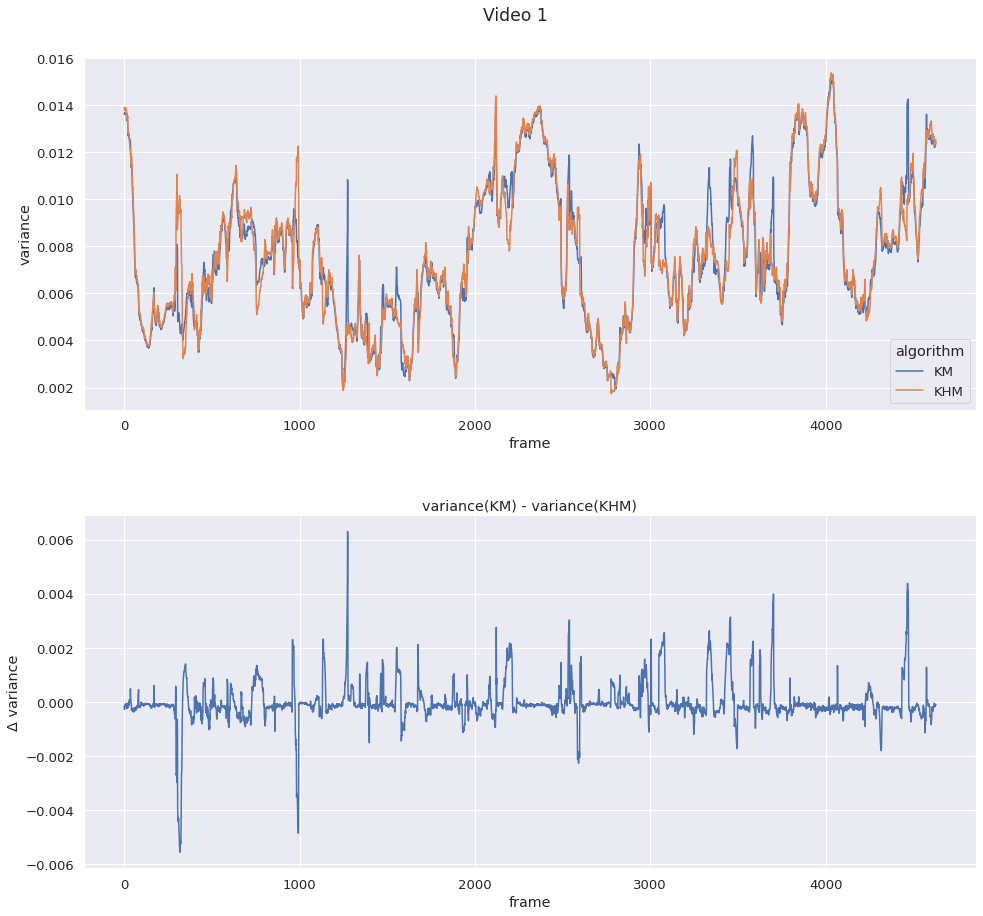

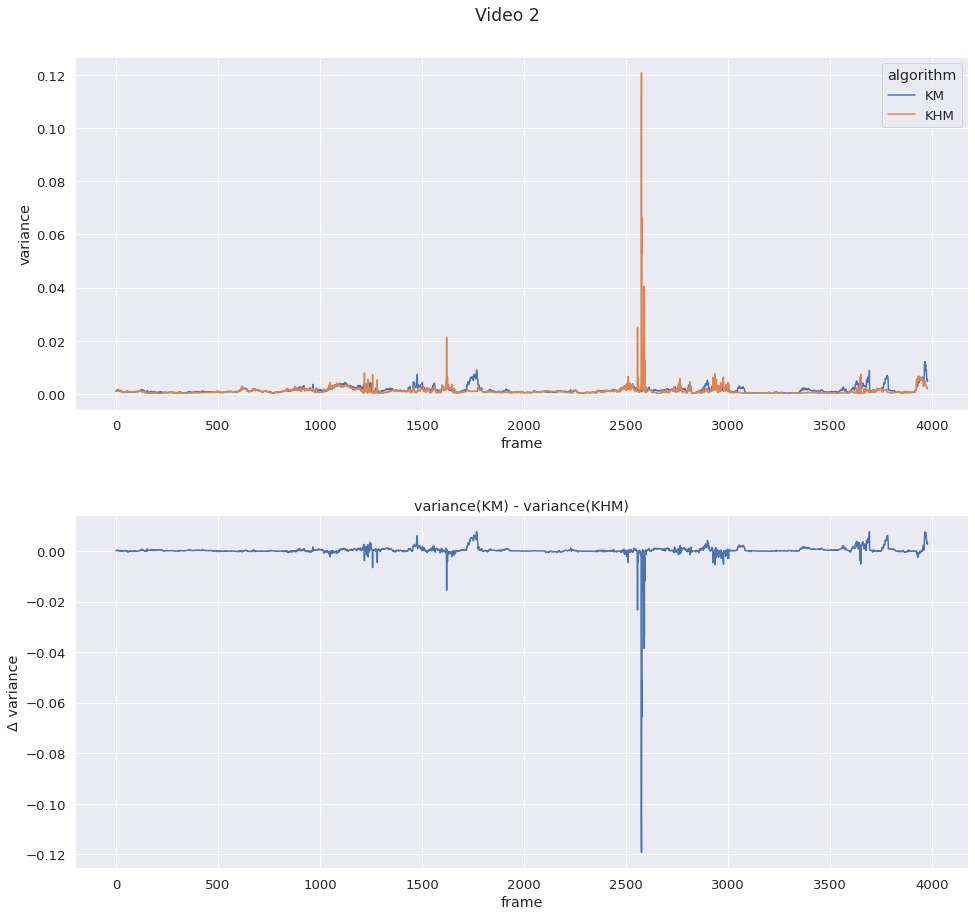

In [21]:
display(Markdown('## Per-frame KM vs KHM'))

def plot_per_frame(video):
    data = pd.DataFrame(
        [
            line
            for measurement_data in [
                list(
                    zip(
                        [algorithm for i in range(len(variances))],
                        [i for i in range(len(variances))],
                        variances
                    )
                )
                for algorithm, variances in [
                    (
                        "KHM" if measurement['settings']["KHM"] == "Yes"
                            else "KM",
                        measurement["variance"]
                    )
                    for measurement in M6
                        if measurement['settings']['number of iterations'] == "3"
                            and measurement['settings']['video file'] == video
                            and (
                                measurement['settings']["KHM"] == "Yes"
                                or measurement['settings']["random swap"] == "No"
                            )
                ]
            ]
            for line in measurement_data
        ],
        columns=["algorithm", "frame", "variance"]
    )
    
    fig, ax = plt.subplots(2,1, figsize=(16,14))
    
    sb.lineplot(
        x=data["frame"],
        y=data["variance"],
        hue=data["algorithm"],
        ci=None,
        ax=ax[0]
    )
    
    #ax[0].set_title("per-frame variance")
    
    data_km = data[data["algorithm"].isin(["KM"])].reset_index()
    data_khm = data[data["algorithm"].isin(["KHM"])].reset_index()
    
    data_diff = data_km.copy()
    del data_diff["algorithm"]
    data_diff["variance"] = [
        data_km.loc[i, "variance"] - data_khm.loc[i, "variance"]
        for i in range(len(data_km["variance"]))
    ]
    
    sb.lineplot(
        x=data_diff["frame"],
        y=data_diff["variance"],
        ci=None,
        ax=ax[1]
    )
    
    ax[1].set_title("variance(KM) - variance(KHM)")
    ax[1].set_ylabel("Δ variance")
    
    fig.suptitle(f"Video {video}")
    
    plt.subplots_adjust(
        hspace=0.3,
        top=0.93
    )
    
    plt.show()
        
plot_per_frame("1")
plot_per_frame("2")

## Alternate KM-KHM

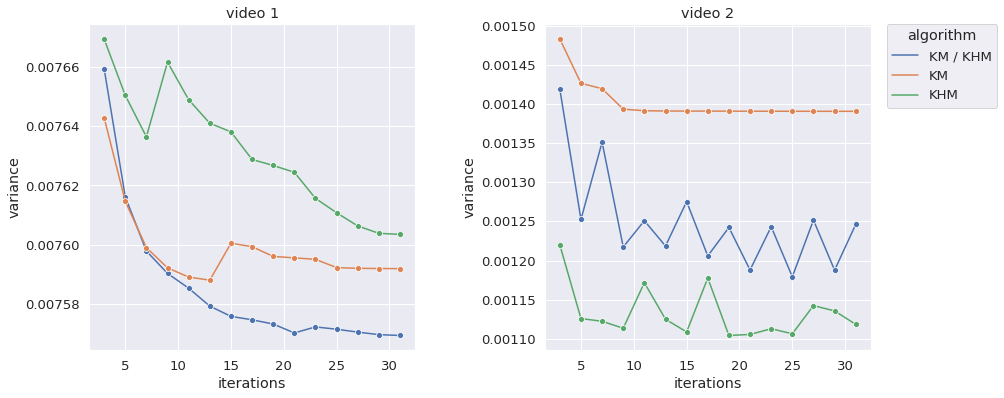

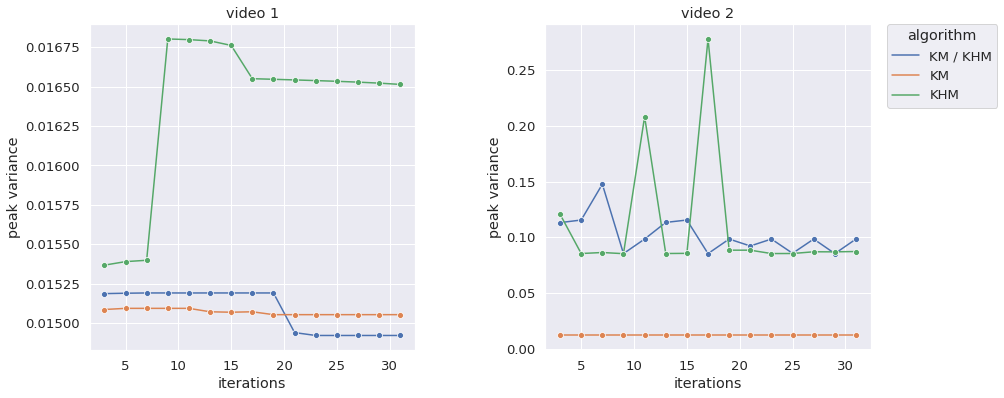


### Compromise

KHM / KM should be enough to avoid local optimum, while reducing downsides of KHM
* slow convergence
* higher peak (mostly due to slow convergence)
        

In [22]:
display(Markdown("## Alternate KM-KHM"))


M_alternate = load_measurements("Alternate KM-KHM")

def plot_alternate():

    def load_video(video_name, measurements):
            return pd.DataFrame(
                [
                    (
                        "KM / KHM",
                        measurement['total variance'], # + (0.00001 if measurement['settings']['random swap'] == "Yes" else 0),
                        measurement['peak variance'],
                        int(measurement['settings']['number of iterations']),
                    )
                        for measurement in measurements
                            if measurement['settings']["video file"] == video_name
                ],
                columns=["mode", "total variance", "peak variance", "number of iterations"]
            )

    data = {
        f"video {video}" : load_video(video, M_alternate)
            for video in ["1", "2"]
    }

    for video in data:
        data[video] = pd.concat(
            [
                data[video],
                pd.DataFrame(
                    [
                        (
                            "KHM" if  measurement['settings']['KHM'] == "Yes"
                                    else
                                        "RS" if measurement['settings']['random swap'] == "Yes"
                                    else
                                        "KM",
                            measurement['total variance'],
                            measurement['peak variance'],
                            int(measurement['settings']['number of iterations']),
                        )
                            for measurement in M6
                                if measurement['settings']["video file"] == video.split(" ")[-1]
                                and measurement['settings']['random swap'] == "No"
                    ],
                    columns=["mode", "total variance", "peak variance", "number of iterations"]
                )
            ]
        ).reset_index()
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["mode"],
            ax=axes[0],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["mode"],
            ax=axes[1],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["mode"],
            ci=None,
            marker='o',
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["mode"],
            ci=None,
            marker='o',
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()

plot_alternate()

display(
    Markdown(
        """
### Compromise

KHM / KM should be enough to avoid local optimum, while reducing downsides of KHM
* slow convergence
* higher peak (mostly due to slow convergence)
        """
    )    
)

In [23]:
display(
    Markdown(
        """
### Thoughts

Look at random swap paper to see which prameters affect KM positively and negatively.

* First video has more color variation (overlap), which was observed to improve KM performance.
        """
    )    
)


### Thoughts

Look at random swap paper to see which prameters affect KM positively and negatively.

* First video has more color variation (overlap), which was observed to improve KM performance.
        

In [24]:
display(
    Markdown(
"""
# Overview

Skim through clustering overview papers once again
"""
    )
)


# Overview

Skim through clustering overview papers once again


In [25]:
display(
    Markdown(
"""
# Future work

* check if alternating KM/KHM can still get out of local optimum like KHM ([datasets](http://cs.joensuu.fi/sipu/datasets/))
"""
    )
)


# Future work

* check if alternating KM/KHM can still get out of local optimum like KHM ([datasets](http://cs.joensuu.fi/sipu/datasets/))


## Alternate KM-KHM test

## Initialization

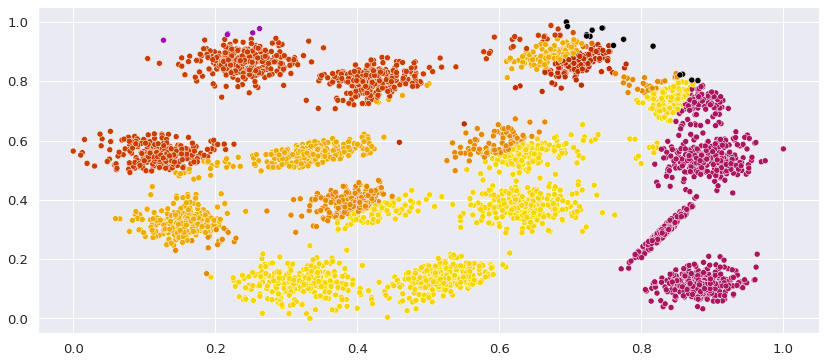

## KM

NUM_ITERATIONS: 10
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 

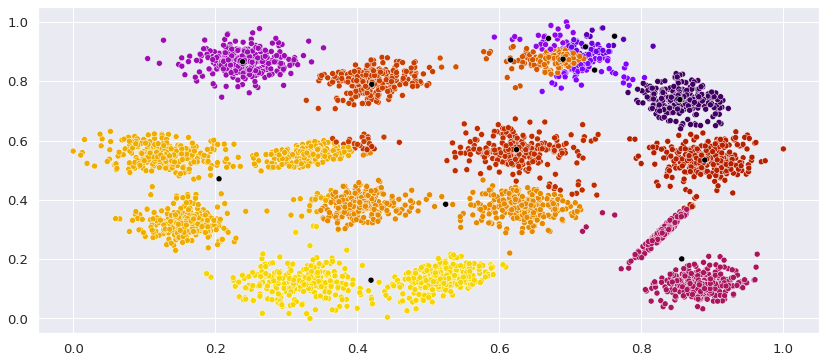

variance: 0.010218025007602275


## KHM

NUM_ITERATIONS: 10
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 

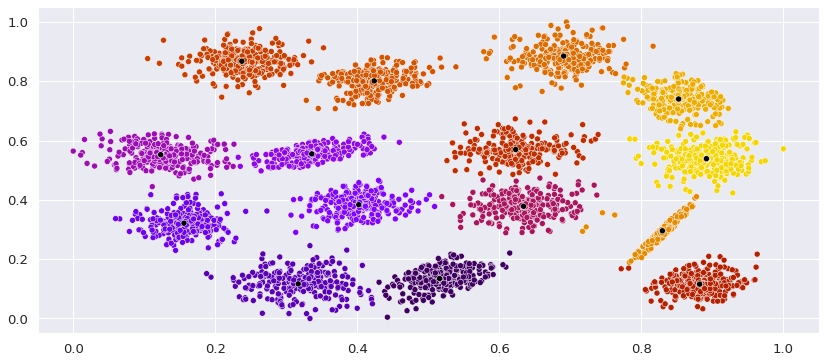

variance: 0.0020618341753954684


## Alternating

NUM_ITERATIONS: 10
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 

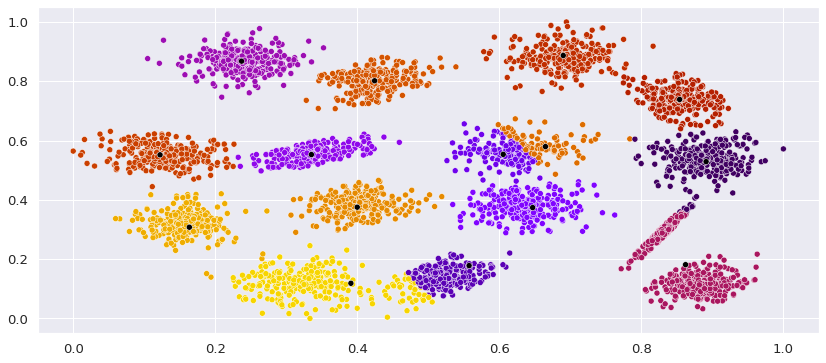

variance: 0.0036907940033291614



### Conclusion

Alternating KHM/KM is almost as good as KHM, but not quite.

Alternating created 1 misplaced mean (KHM had no misplaced means)
and slightly increased variance, but not nearly as bad as KM alone.



In [26]:
display(Markdown("## Alternate KM-KHM test"))

def verify_alternating():
    NUM_CLUSTERS = 15
    NUM_ITERATIONS = 10
    
    #with open("Datasets/Birch/Birch1.txt") as file:
    with open("Datasets/S/S1.txt") as file:
        points = [
           filter(
                lambda x: x != '',
                line.split(" ")
            )
            for line in file.readlines()
        ]
        points = [
            tuple([int(coord.replace("/n", "")) for coord in point])
            for point in points
        ]
        
        _ = """
        points = [
            points[random_index]
            for random_index in np.random.choice(
                len(points), 10000, replace=False
            )
        ]
        """
        
        def normalize_points(points):
            transposed_points = list(zip(*points))
            
            min_coords = [
                min(coord_list)
                for coord_list in transposed_points
            ]

            max_coords = [
                max(coord_list)
                for coord_list in transposed_points
            ]

            coords_range = [
                max_coord - min_coord
                for max_coord, min_coord in zip(max_coords, min_coords)
            ]

            def normalize_point(point):
                return [
                    (coord - min_coord) / range_coord
                    for coord, min_coord, range_coord in zip(point, min_coords, coords_range)
                ]
        
            return [
                normalize_point(point)
                for point in points
            ]
        
        points = normalize_points(points)
    
    def init_means(points):               
        return sorted(
            points, 
            key = lambda point: -sum(point)
        )[0:NUM_CLUSTERS]
        
    def distance(point_1, point_2):
        def pow2(x):
            return x*x

        dist = sum(
            [
                pow2(
                    point_1[i] - point_2[i]
                )
                for i in range(len(point_1))
            ]
        )
        
        return math.sqrt(dist)

    def get_attribution(means):
        attribution = [0] * len(points)

        for point_index in range(len(points)):
            distances = [
                distance(
                    points[point_index],
                    means[mean_index]
                )
                for mean_index in range(len(means))
            ]
            
            for mean_index in range(len(distances)):
                if distances[mean_index] == min(distances):
                    attribution[point_index] = mean_index

        return attribution

        plt.show()
    
    def km_weights(means):
        attribution = get_attribution(means)

        return [
            [
                1
                    if attribution[point_index] == mean_index
                    else
                0
                for mean_index in range(len(means))
            ]
            for point_index in range(len(points))
        ]
    
    def khm_weights(means):
        P = 3
        
        def point_weights(point):
            distances = [
                distance(point, mean)
                for mean in means
            ]

            min_distance = min(distances)
            
            def mean_weight(mean_index):
            
                top = pow(min_distance, P - 2)
                if distances[mean_index] != min_distance:
                    top = top * math.pow(
                        min_distance / distances[mean_index],
                        P + 2
                    )

                bot = sum(
                    [
                        (
                            math.pow(
                                min_distance / distances[other_mean_index],
                                P
                            )
                                if distances[other_mean_index] != min_distance
                                else
                            1
                        )
                        for other_mean_index in range(len(means))
                    ]
                )

                return top / (bot * bot)
            
            return [
                mean_weight(mean_index)
                for mean_index in range(len(means))
           ]
        
        return [
            point_weights(point)
            for point in points
        ]
    
    def update_means(means, weighting):

        weights = weighting(means)
        
        def coord_weighted_avg(mean_index, coord_index):
            weighted_sum = sum(
                [
                    weights[point_index][mean_index] * points[point_index][coord_index]
                    for point_index in range(len(points))
                ]
            )

            sum_weights = sum(
                weights[point_index][mean_index]
                for point_index in range(len(points))
            )
            
            if sum_weights == 0:
                return means[mean_index][coord_index]
        
            return weighted_sum / sum_weights

        return [
            [
                coord_weighted_avg(mean_index, coord_index)                
                for coord_index in range(len(points[0]))
            ]
            for mean_index in range(len(means))
        ]
    
    def measure_variance(means):
        def point_variance(point):
            distances = [
                distance(point, mean)
                for mean in means
            ]

            min_distance = min(distances)

            return min_distance * min_distance
        
        point_variances = [
            point_variance(point)
            for point in points
        ]
        
        return sum(point_variances) / len(point_variances)
    
    def print_variance(means):
        variance = measure_variance(means)
        print(f"variance: {variance}")
    
    def show_plot(means):        
        sb.scatterplot(
            x=list(zip(*points))[0],
            y=list(zip(*points))[1],
            hue=get_attribution(means),
            palette=sb.color_palette(
                "hls", 
                len(
                    set(
                        get_attribution(means)
                    )
                )
            ),
        ).legend().remove()
        
        ax.get_xaxis().set_visible(False)

        plt.show()
    
    def print_progress(i):
        if i == 0:
            print(f"NUM_ITERATIONS: {NUM_ITERATIONS}")
        print(f"{i}... ", end="")
    
    def show_means(means):
        sb.scatterplot(
            x=list(zip(*points))[0],
            y=list(zip(*points))[1],
            hue=get_attribution(means),
            palette=sb.color_palette(
                "gnuplot", 
                len(
                    set(
                        get_attribution(means)
                    )
                )
            ),
        )
        
        sb.scatterplot(
            x=list(zip(*means))[0],
            y=list(zip(*means))[1],
            hue=[-1 for i in range(len(list(zip(*means))[0]))],
            palette=["black"]
        ).legend().remove()
        
        plt.show()
    
    means = init_means(points)
    display(Markdown("## Initialization"))
    show_means(means)
    display(Markdown("## KM"))
    for i in range(NUM_ITERATIONS):
        means = update_means(means, km_weights)
        print_progress(i)
    show_means(means)
    print_variance(means)
    
    display(Markdown("## KHM"))
    means = init_means(points)
    for i in range(NUM_ITERATIONS):
        means = update_means(means, khm_weights)
        print_progress(i)
    show_means(means)
    print_variance(means)
    
    display(Markdown("## Alternating"))
    means = init_means(points)
    for i in range(NUM_ITERATIONS):
        means = update_means(
            means,
            (
                km_weights
                    if i % 2 == 0
                    else
                khm_weights
            )
        )
        print_progress(i)
    show_means(means)
    print_variance(means)

#%snakeviz verify_alternating()
verify_alternating()

display(
    Markdown(
"""
### Conclusion

Alternating KHM/KM is almost as good as KHM, but not quite.

Alternating created 1 misplaced mean (KHM had no misplaced means)
and slightly increased variance, but not nearly as bad as KM alone.

"""
    )
)